In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019075A7BE08>,
      dtype=object)

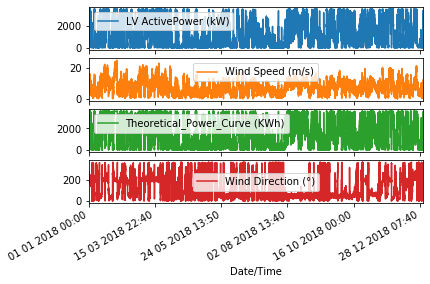

In [46]:
df=pd.read_csv("T1.csv")
#print(df)
print(df.columns)
features_considered = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
features = df[features_considered]
features.index = df['Date/Time']
features.head()
features.plot(subplots=True)

In [4]:
#dataset scaling
TRAIN_SPLIT=(int)(len(df)*0.6)
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [6]:
past_history = 60
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target  to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 4)

 Target  to predict : (6,)


In [7]:
BATCH_SIZE = 512
BUFFER_SIZE = BATCH_SIZE*BATCH_SIZE

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [8]:
def create_time_steps(length):
  return list(range(-length, 0))

In [9]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

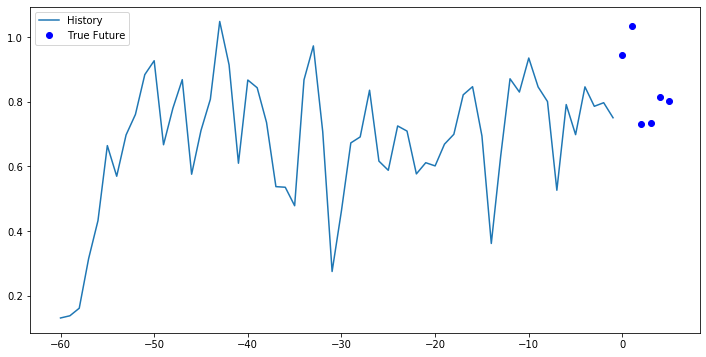

In [10]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [11]:
#creating new trained model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(216,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(tf.keras.layers.LSTM(60, activation='relu'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [27]:
#get previous trained model
multi_step_modell = tf.keras.models.load_model('Trained_Model.h5')

In [37]:
EVALUATION_INTERVAL = 36
EPOCHS = 10
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=36)

Train for 36 steps, validate for 36 steps
Epoch 1/10
36/36 [==============================] - 4s 117ms/step - loss: 0.2162 - val_loss: 0.1902
Epoch 2/10
36/36 [==============================] - 4s 114ms/step - loss: 0.2203 - val_loss: 0.1899
Epoch 3/10
36/36 [==============================] - 4s 118ms/step - loss: 0.2187 - val_loss: 0.1955
Epoch 4/10
36/36 [==============================] - 4s 115ms/step - loss: 0.2175 - val_loss: 0.1899
Epoch 5/10
36/36 [==============================] - 4s 116ms/step - loss: 0.2166 - val_loss: 0.1899
Epoch 6/10
36/36 [==============================] - 4s 118ms/step - loss: 0.2175 - val_loss: 0.1900
Epoch 7/10
36/36 [==============================] - 4s 116ms/step - loss: 0.2169 - val_loss: 0.1942
Epoch 8/10
36/36 [==============================] - 4s 118ms/step - loss: 0.2169 - val_loss: 0.1946
Epoch 9/10
36/36 [==============================] - 4s 117ms/step - loss: 0.2166 - val_loss: 0.1894
Epoch 10/10
36/36 [==============================] - 4s 11

In [39]:
#save trained model
multi_step_model.save('Trained_Model.h5')

In [40]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

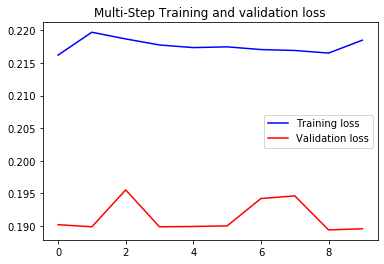

In [41]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

[2870.65523454   13.04050567 3152.35068409  268.32831577]
[2839.92012067   12.93582139 3120.01782392  266.02728611]
[2849.89371017   12.96979159 3130.50988443  266.77397361]
[2821.14214831   12.87186332 3100.26369001  264.6214455 ]
[2810.90547203   12.83699704 3089.4948663   263.85506162]
[2807.20130185   12.82438057 3085.59813707  263.57774346]


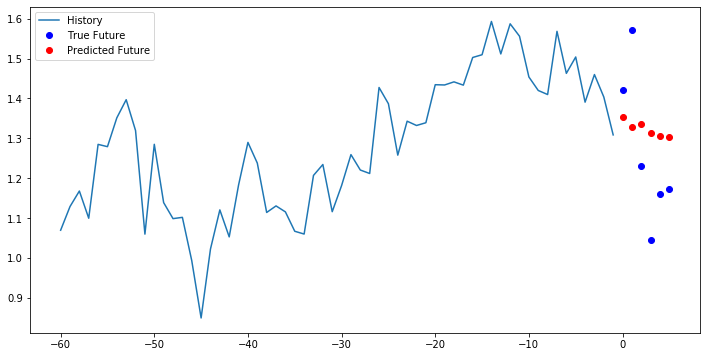

[1692.15793502    9.02652523 1912.58991487  180.09837629]
[1681.80034589    8.99124712 1901.69389273  179.32294009]
[1687.18173258    9.0095762  1907.35502755  179.72582555]
[1673.49739573    8.96296714 1892.95931873  178.70132748]
[1670.72534815    8.9535255  1890.04316793  178.49379404]
[1666.33478148    8.93857116 1885.42436031  178.16508779]


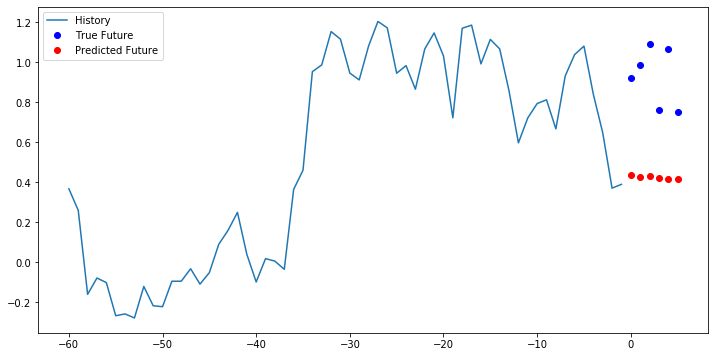

[2114.76728021   10.46593934 2357.1683514   211.73764858]
[2091.22353659   10.38574898 2332.4007005   209.97501147]
[2094.52948209   10.39700908 2335.87850359  210.22251595]
[2072.31050282   10.32133089 2312.5044841   208.55905928]
[2066.59570716   10.3018662  2306.49260825  208.13121267]
[2060.49362328   10.28108241 2300.07331123  207.67437116]


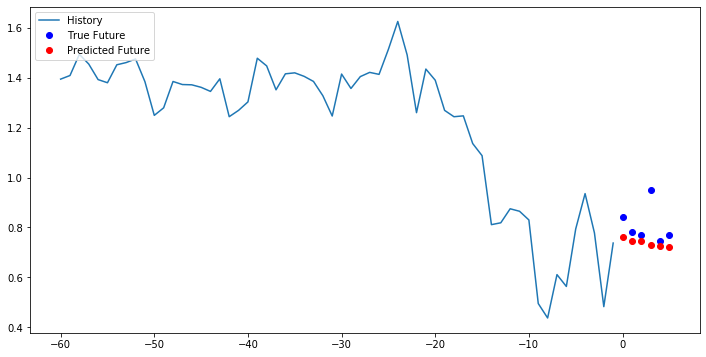

[ 830.62033071    6.09211452 1006.26579901  115.59809214]
[ 836.00378232    6.11045064 1011.9291061   116.00113219]
[ 842.04074458    6.13101263 1018.27989618  116.45309827]
[ 844.84233206    6.14055488 1021.2271225   116.66284326]
[ 852.83711123    6.16778523 1029.63750543  117.2613842 ]
[ 855.10797465    6.17551982 1032.02641832  117.43139574]


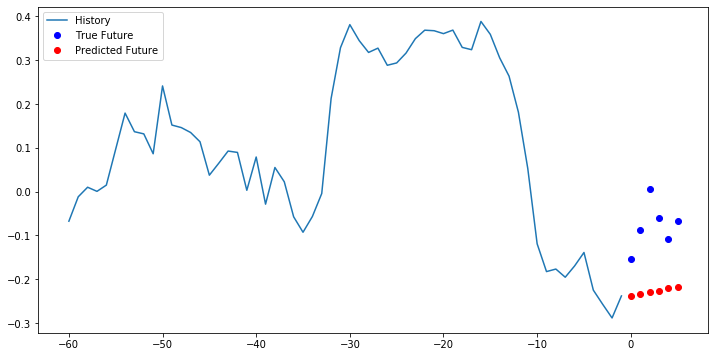

[2660.04447246   12.32316209 2930.79144887  252.56063026]
[2623.55571176   12.19888079 2892.405842    249.82884534]
[2628.10894866   12.21438919 2897.19577616  250.16973014]
[2596.81508129   12.10780178 2864.27511602  247.82686858]
[2586.47944154   12.07259843 2853.40218429  247.05307566]
[2578.52825524   12.04551656 2845.03766038  246.45779836]


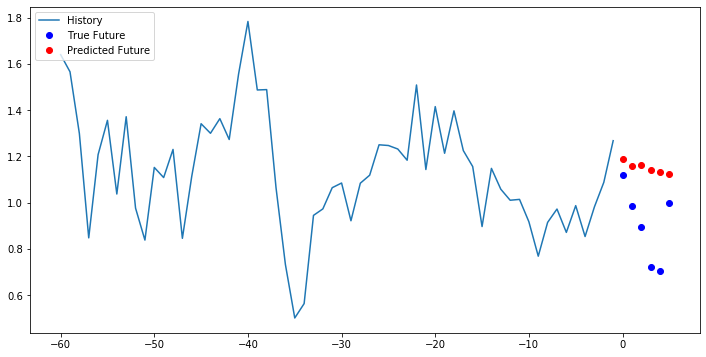

[3215.47528511   14.21496822 3515.09599655  294.14377772]
[3176.24353874   14.08134427 3473.82481156  291.20663513]
[3185.04547428   14.1113238  3483.08431041  291.86560503]
[3149.3328196    13.98968594 3445.51515496  289.19192443]
[3137.47663      13.94930357 3433.04262851  288.3042933 ]
[3131.36827487   13.92849841 3426.61673423  287.84698228]


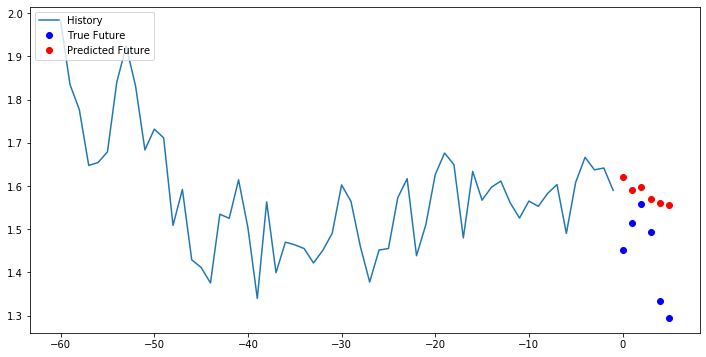

In [44]:
multi_step_modell = tf.keras.models.load_model('Trained_Model.h5')
for x, y in val_data_multi.take(6):
  for i in range(0,6):
    #upscaled result
    print((multi_step_model.predict(x)[0][i]*data_std)+data_mean)
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])